In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


In [ ]:
!unzip /content/content2.zip -d /content/content2

Archive:  /content/content2.zip
   creating: /content/content2/content2/
   creating: /content/content2/content2/skeletonized/
   creating: /content/content2/content2/skeletonized/Bharadvajas Twist/
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/1. Bharadvajas Twist.png  
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/10. Bharadvajas Twist.png  
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/11. Bharadvajas Twist.png  
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/12. Bharadvajas Twist.png  
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/13. Bharadvajas Twist.png  
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/14. Bharadvajas Twist.png  
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/15. Bharadvajas Twist.png  
  inflating: /content/content2/content2/skeletonized/Bharadvajas Twist/16. Bharadvajas Twist.png  
  inflatin

In [ ]:
# Define the path to your dataset
data_dir = '/content/content2/content2/skeletonized'
#careful

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [ ]:
# Define the split sizes
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Define batch size
batch_size = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

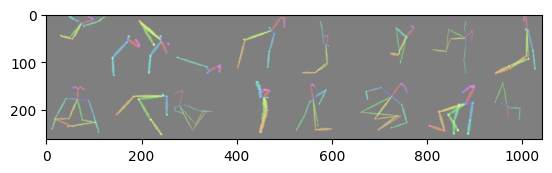

Lord of the Dance Pose Crane Pose Legs Up The Wall Pose Camel Pose Monkey Pose Half Frog Pose Supine Spinal Twist Upward Facing Dog Scale Pose Camel Pose Full Boat Pose Mountain Pose Half Frog Pose Noose Pose Cow Pose Wide-Legged Forward Bend


In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{dataset.classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
!nvidia-smi

Tue Aug 13 22:22:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### training with plots


In [ ]:
import torch

def compute_validation_loss(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, labels in val_loader:
            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Accumulate loss and the number of samples
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

    # Calculate average loss over all validation samples
    avg_loss = total_loss / total_samples
    return avg_loss


In [ ]:
import torch
from collections import Counter

# Assuming you have a dataset object and can access labels
# Get all labels from the dataset (train set preferred)
all_labels = []
# Global list to store learning rate histories from different runs
global_lr_histories = []

for _, labels in train_loader:
    all_labels.extend(labels.numpy())

# Count the frequency of each class
class_counts = Counter(all_labels)

# Calculate the weights
total_samples = sum(class_counts.values())
class_weights = {class_idx: total_samples/class_counts[class_idx] for class_idx in class_counts}

# Convert to tensor and align with your class indices
weights = torch.tensor([class_weights[i] for i in range(len(dataset.classes))], dtype=torch.float32)


In [ ]:
global_val_loss_batch_size = []
global_train_loss_batch_size = []
global_val_accuracy_batch_size = []
global_train_accuracy_batch_size = []

In [ ]:
def get_accuracy2(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(len(dataset.classes)))
    class_total = list(0. for i in range(len(dataset.classes)))

    with torch.no_grad():
        for imgs, labels in dataloader:
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item() if c.dim() > 0 else c.item()
                class_total[label] += 1
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    overall_accuracy = correct / total
    class_accuracy = [(dataset.classes[i], class_correct[i] / class_total[i]) for i in range(len(dataset.classes)) if class_total[i] > 0]

    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    # print(f"Class Accuracy: {class_accuracy}")

    return overall_accuracy


In [ ]:
def train_plot2(model, num_epochs, batch_size, learning_rate=0.001, weights = weights, patience=4, run_id = "None"):
    # Move the weights to GPU if available
    if use_cuda and torch.cuda.is_available():
        weights = weights.cuda()

    # Apply the weights to the loss function
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=0)

    iters, losses, train_acc, valid_acc = [], [], [], []
    val_losses, train_losses = [], []  # To track loss values for plotting
    lr_history = []  # To track learning rate changes
    start_time = time.time()

    best_val_accuracy = 0
    best_train_accuracy = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i + 1) % len(train_loader) == 0:
                iters.append(epoch * len(train_loader) + i)
                # losses.append(running_loss / len(train_loader))
                current_val_accuracy = get_accuracy2(model, val_loader)
                current_train_accuracy = get_accuracy2(model, train_loader)
                valid_acc.append(current_val_accuracy)
                train_acc.append(current_train_accuracy)

                val_loss = compute_validation_loss(model, val_loader, criterion)
                train_loss = compute_validation_loss(model, train_loader, criterion)
                val_losses.append(val_loss)
                train_losses.append(train_loss)
                # scheduler.step(val_loss)

                # Track the learning rate
                # lr_val = optimizer.param_groups[0]['lr']
                # lr_history.append(lr_val)

                print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.3f}')
                # print(f'Current Learning Rate: {lr_val}')
                print(f"\tTime Elapsed: {time.time() - start_time:.2f} s")

                running_loss = 0.0

                if current_val_accuracy > best_val_accuracy:
                    best_val_accuracy = current_val_accuracy
                    patience_counter = 0  # Reset patience counter
                else:
                    patience_counter += 1

                if current_train_accuracy > best_train_accuracy:
                    best_train_accuracy = current_train_accuracy

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    print("Final Training Accuracy: {}".format(best_train_accuracy))
    print("Final Validation Accuracy: {}".format(best_val_accuracy))

    plt.title("Losses")
    plt.plot(iters, train_losses, label="Train losses")
    plt.plot(iters, val_losses, label="Val losses")
    plt.legend(loc='best')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy")
    plt.plot(iters, valid_acc, label="Validation")
    plt.plot(iters, train_acc, label="Training")
    plt.legend(loc='best')
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.show()

    # # Plotting the learning rate history
    # plt.figure()
    # plt.title("Learning Rate Schedule")
    # plt.plot(range(len(lr_history)), lr_history, label="Learning Rate")
    # plt.xlabel("Epoch")
    # plt.ylabel("Learning Rate")
    # plt.legend(loc='best')
    # plt.show()

    # Store the learning rate history in the global list with a run identifier
    # global_lr_histories.append((run_id, lr_history))
        # Store the metrics in global lists
    # global_val_loss_batch_size.append((batch_size, val_losses))
    # global_train_loss_batch_size.append((batch_size, train_losses))
    # global_val_accuracy_batch_size.append((batch_size, valid_acc))
    # global_train_accuracy_batch_size.append((batch_size, train_acc))

In [ ]:
def plot_global_lr_histories():
    plt.figure()
    for run_id, lr_hist in global_lr_histories:
        plt.plot(range(len(lr_hist)), lr_hist, label=f'{run_id}')
    plt.title("Learning Rate Schedules Across Runs")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def plot_global_metrics():
    # Plot validation loss for different batch sizes
    plt.figure()
    for batch_size, val_losses in global_val_loss_batch_size:
        plt.plot(range(len(val_losses)), val_losses, label=f'Batch Size {batch_size}')
    plt.title("Validation Loss vs. Epochs for Different Batch Sizes")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.legend(loc='best')
    plt.show()

    # Plot training loss for different batch sizes
    plt.figure()
    for batch_size, train_losses in global_train_loss_batch_size:
        plt.plot(range(len(train_losses)), train_losses, label=f'Batch Size {batch_size}')
    plt.title("Training Loss vs. Epochs for Different Batch Sizes")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend(loc='best')
    plt.show()

    # Plot validation accuracy for different batch sizes
    plt.figure()
    for batch_size, val_acc in global_val_accuracy_batch_size:
        plt.plot(range(len(val_acc)), val_acc, label=f'Batch Size {batch_size}')
    plt.title("Validation Accuracy vs. Epochs for Different Batch Sizes")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    # Plot training accuracy for different batch sizes
    plt.figure()
    for batch_size, train_acc in global_train_accuracy_batch_size:
        plt.plot(range(len(train_acc)), train_acc, label=f'Batch Size {batch_size}')
    plt.title("Training Accuracy vs. Epochs for Different Batch Sizes")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

### Model Testing

### RESIDUAL NETWORK WITH SIMPLE CNN

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()

        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetSimpleCNN(nn.Module):
    def __init__(self):
        super(ResNetSimpleCNN, self).__init__()
        self.block1 = ResidualBlock(3, 32)
        self.pool = nn.MaxPool2d(2, 2)
        self.block2 = ResidualBlock(32, 64)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, len(dataset.classes))

    def forward(self, x):
        x = self.pool(self.block1(x))
        x = self.pool(self.block2(x))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### Learning Rate Tuning

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.0228
Overall Accuracy: 0.0239
Epoch 1, Loss: 150.001
Current Learning Rate: 0.1
	Time Elapsed: 12.92 s
Overall Accuracy: 0.0068
Overall Accuracy: 0.0127
Epoch 1, Loss: 1.038
Current Learning Rate: 0.1
	Time Elapsed: 25.84 s
Overall Accuracy: 0.0228
Overall Accuracy: 0.0235
Epoch 1, Loss: 1.016
Current Learning Rate: 0.1
	Time Elapsed: 38.75 s
Overall Accuracy: 0.0183
Overall Accuracy: 0.0127
Epoch 1, Loss: 1.012
Current Learning Rate: 0.1
	Time Elapsed: 51.66 s
Overall Accuracy: 0.0251
Overall Accuracy: 0.0230
Epoch 2, Loss: 1.012
Current Learning Rate: 0.1
	Time Elapsed: 64.60 s
Overall Accuracy: 0.0137
Overall Accuracy: 0.0200
Epoch 2, Loss: 1.017
Current Learning Rate: 0.05
	Time Elapsed: 77.92 s
Overall Accuracy: 0.0068
Overall Accuracy: 0.0200
Epoch 2, Loss: 1.014
Current Learning Rate: 0.05
	Time Elapsed: 90.89 s
Overall Accuracy: 0.0274
Overall Accuracy: 0.0244
Epoch 2, Loss: 1.012
Current Learning Rate: 0.05
	Time Elap

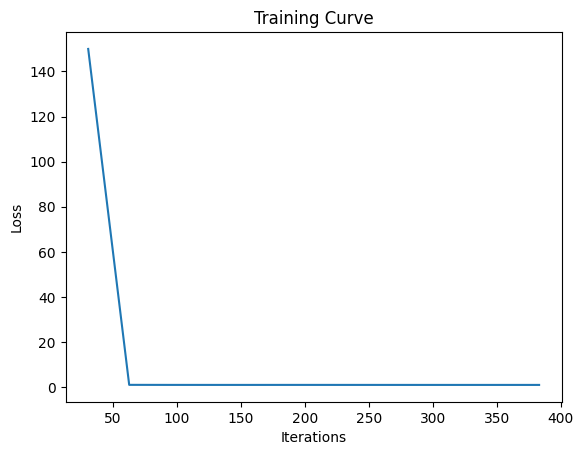

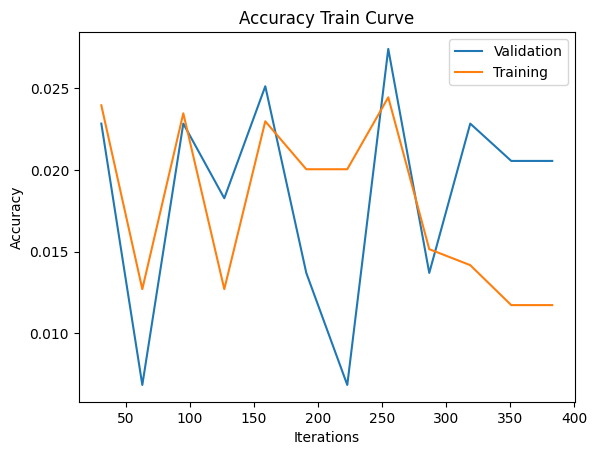

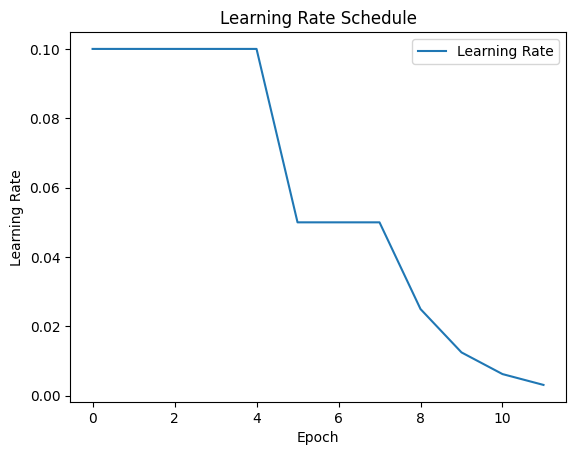

In [ ]:
'''Set Learning Rate to 0.1'''
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, learning_rate=0.1, run_id="lr_0.1")

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.0137
Overall Accuracy: 0.0181
Epoch 1, Loss: 25.175
Current Learning Rate: 0.05
	Time Elapsed: 13.25 s
Overall Accuracy: 0.0183
Overall Accuracy: 0.0171
Epoch 1, Loss: 1.018
Current Learning Rate: 0.05
	Time Elapsed: 26.17 s
Overall Accuracy: 0.0091
Overall Accuracy: 0.0176
Epoch 1, Loss: 1.011
Current Learning Rate: 0.025
	Time Elapsed: 39.17 s
Overall Accuracy: 0.0228
Overall Accuracy: 0.0235
Epoch 1, Loss: 1.009
Current Learning Rate: 0.025
	Time Elapsed: 52.09 s
Overall Accuracy: 0.0297
Overall Accuracy: 0.0200
Epoch 2, Loss: 1.003
Current Learning Rate: 0.0125
	Time Elapsed: 65.07 s
Overall Accuracy: 0.0228
Overall Accuracy: 0.0147
Epoch 2, Loss: 1.005
Current Learning Rate: 0.00625
	Time Elapsed: 78.04 s
Overall Accuracy: 0.0228
Overall Accuracy: 0.0147
Epoch 2, Loss: 1.004
Current Learning Rate: 0.003125
	Time Elapsed: 90.91 s
Overall Accuracy: 0.0137
Overall Accuracy: 0.0142
Epoch 2, Loss: 1.009
Current Learning Rate: 

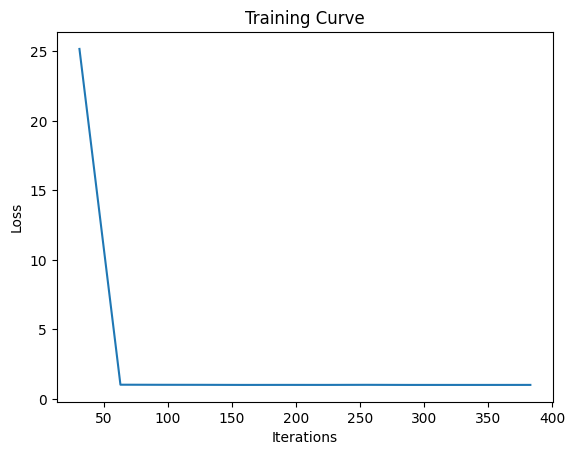

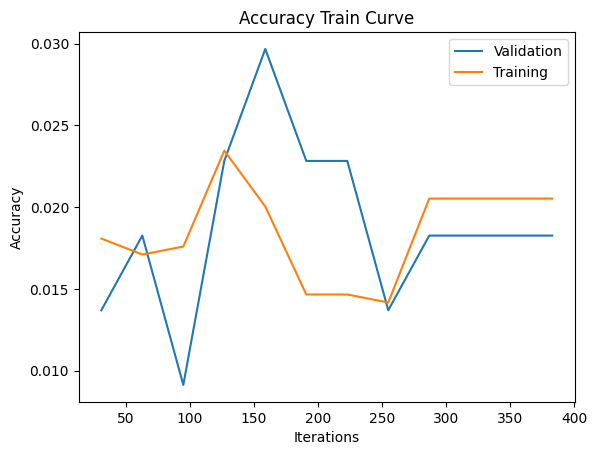

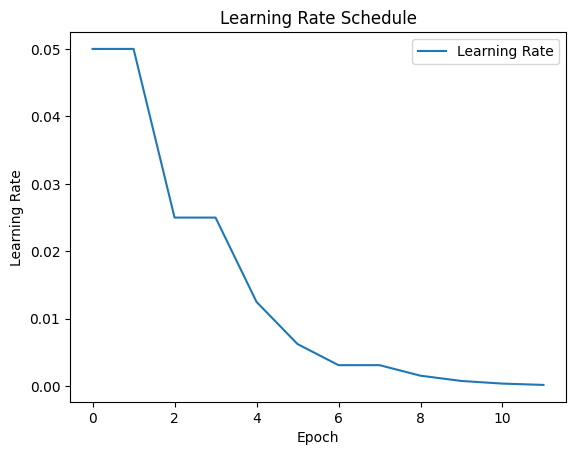

In [ ]:
'''Set Learning Rate to 0.05'''
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, learning_rate=0.05, run_id="lr_0.05")

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.3927
Class Accuracy: [('Bharadvajas Twist', 0.6666666666666666), ('Bound Angle Pose', 0.18181818181818182), ('Bow Pose', 0.6666666666666666), ('Camel Pose', 0.8), ('Chair Pose', 0.3333333333333333), ('Cobra Pose', 0.125), ('Cow Face Pose', 0.36363636363636365), ('Cow Pose', 0.5909090909090909), ('Crane Pose', 0.36363636363636365), ('Crescent Moon Pose', 0.3333333333333333), ('Downward Dog Pose', 0.4444444444444444), ('Eagle Pose', 1.0), ('Easy Pose', 0.6), ('Embryo Pose', 0.3333333333333333), ('Extended Hand to Big Toe Pose', 0.45454545454545453), ('Extended Side Angle Pose', 0.36363636363636365), ('Extended Triangle Pose', 0.38461538461538464), ('Formidable Pose', 0.42857142857142855), ('Four-Limbed Staff Pose', 0.5), ('Frog Pose', 0.5), ('Full Boat Pose', 0.5), ('Garland Pose', 0.38461538461538464), ('Half Feather Peacock Pose', 0.0), ('Half Frog Pose', 0.0), ('Half Lord of the Fishes Pose', 0.35), ('Half Moon Pose', 0.5), (

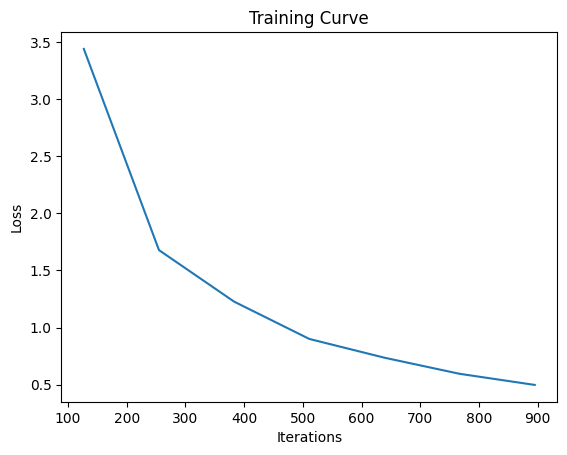

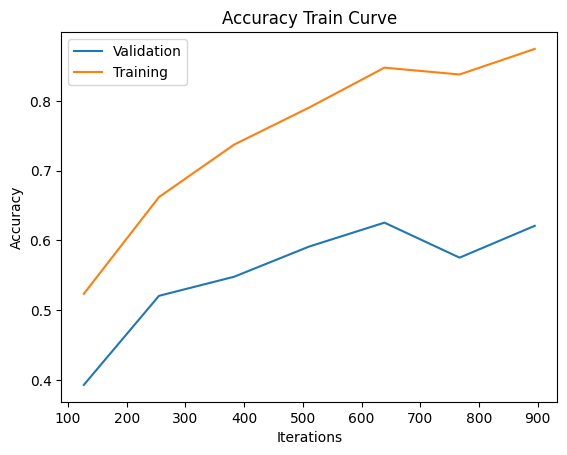

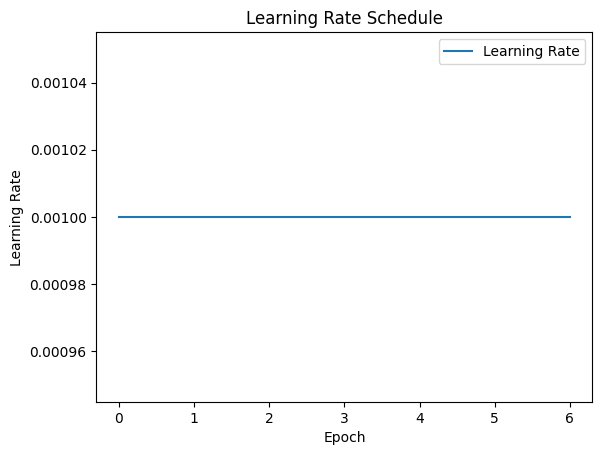

In [ ]:
'''Set Learning Rate to 0.001'''
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, learning_rate=0.001, run_id="lr_0.001")

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.0137
Overall Accuracy: 0.0181
Epoch 1, Loss: 4.544
Current Learning Rate: 0.01
	Time Elapsed: 12.89 s
Overall Accuracy: 0.0913
Overall Accuracy: 0.1183
Epoch 1, Loss: 0.955
Current Learning Rate: 0.01
	Time Elapsed: 26.02 s
Overall Accuracy: 0.1963
Overall Accuracy: 0.1994
Epoch 1, Loss: 0.834
Current Learning Rate: 0.01
	Time Elapsed: 39.32 s
Overall Accuracy: 0.2763
Overall Accuracy: 0.3016
Epoch 1, Loss: 0.758
Current Learning Rate: 0.01
	Time Elapsed: 52.45 s
Overall Accuracy: 0.2329
Overall Accuracy: 0.2571
Epoch 2, Loss: 0.830
Current Learning Rate: 0.005
	Time Elapsed: 65.46 s
Overall Accuracy: 0.3014
Overall Accuracy: 0.3270
Epoch 2, Loss: 0.683
Current Learning Rate: 0.005
	Time Elapsed: 78.36 s
Overall Accuracy: 0.3447
Overall Accuracy: 0.4066
Epoch 2, Loss: 0.627
Current Learning Rate: 0.005
	Time Elapsed: 91.43 s
Overall Accuracy: 0.3904
Overall Accuracy: 0.4775
Epoch 2, Loss: 0.586
Current Learning Rate: 0.005
	Ti

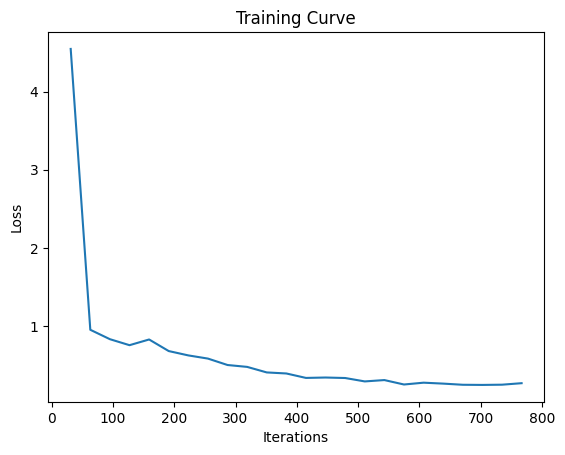

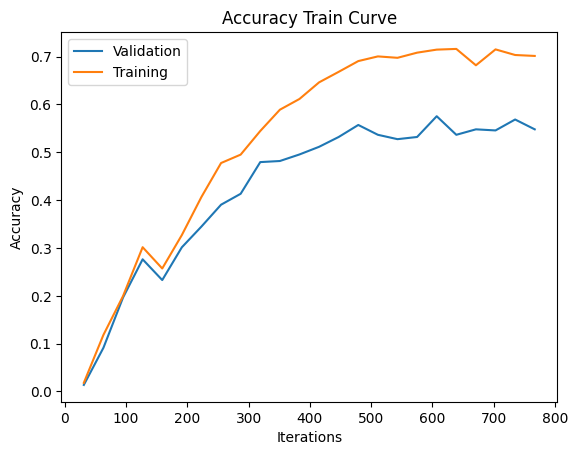

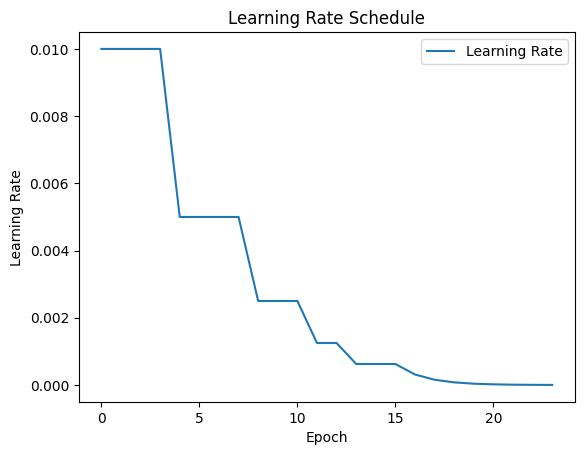

In [ ]:
'''Set Learning Rate to 0.01'''
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, learning_rate=0.01, run_id="lr_0.01")

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.0274
Class Accuracy: [('Bharadvajas Twist', 0.0), ('Bound Angle Pose', 0.0), ('Bow Pose', 0.0), ('Camel Pose', 0.0), ('Chair Pose', 0.0), ('Cobra Pose', 0.0), ('Cow Face Pose', 0.0), ('Cow Pose', 0.18181818181818182), ('Crane Pose', 0.0), ('Crescent Moon Pose', 0.7777777777777778), ('Downward Dog Pose', 0.0), ('Eagle Pose', 0.0), ('Easy Pose', 0.0), ('Embryo Pose', 0.0), ('Extended Hand to Big Toe Pose', 0.0), ('Extended Side Angle Pose', 0.0), ('Extended Triangle Pose', 0.0), ('Formidable Pose', 0.0), ('Four-Limbed Staff Pose', 0.0), ('Frog Pose', 0.0), ('Full Boat Pose', 0.0), ('Garland Pose', 0.0), ('Half Feather Peacock Pose', 0.0), ('Half Frog Pose', 0.0), ('Half Lord of the Fishes Pose', 0.0), ('Half Moon Pose', 0.0), ('Hero Pose', 0.0), ('Heron Pose', 0.0), ('High Lunge', 0.0), ('Intense Side Stretch Pose', 0.0), ('Legs Up The Wall Pose', 0.0), ('Lord of the Dance Pose', 0.0), ('Lotus Pose', 0.0), ('Monkey Pose', 0.0), 

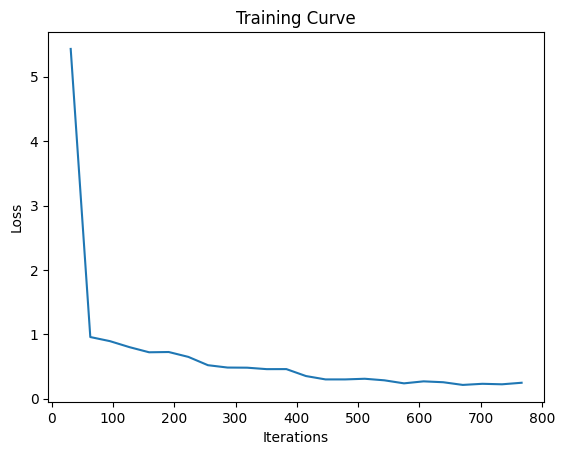

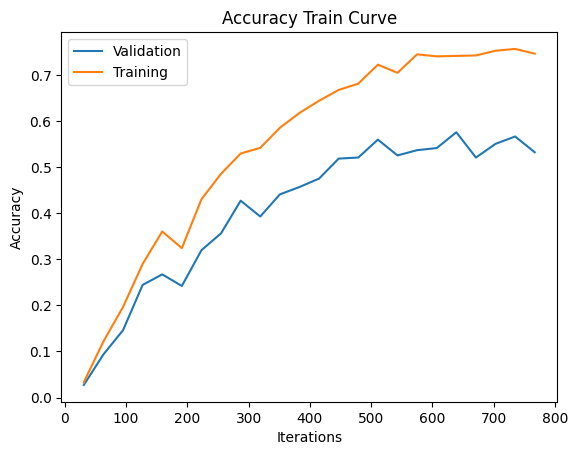

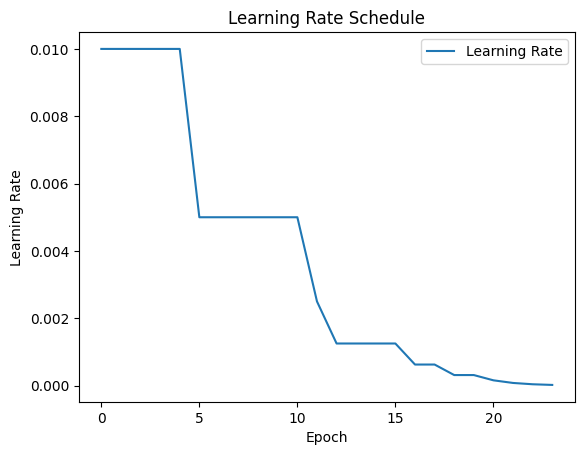

In [ ]:
'''Set Learning Rate to 0.01'''
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, learning_rate=0.01)

In [ ]:
'''Pick Learning Rate at 0.00015'''

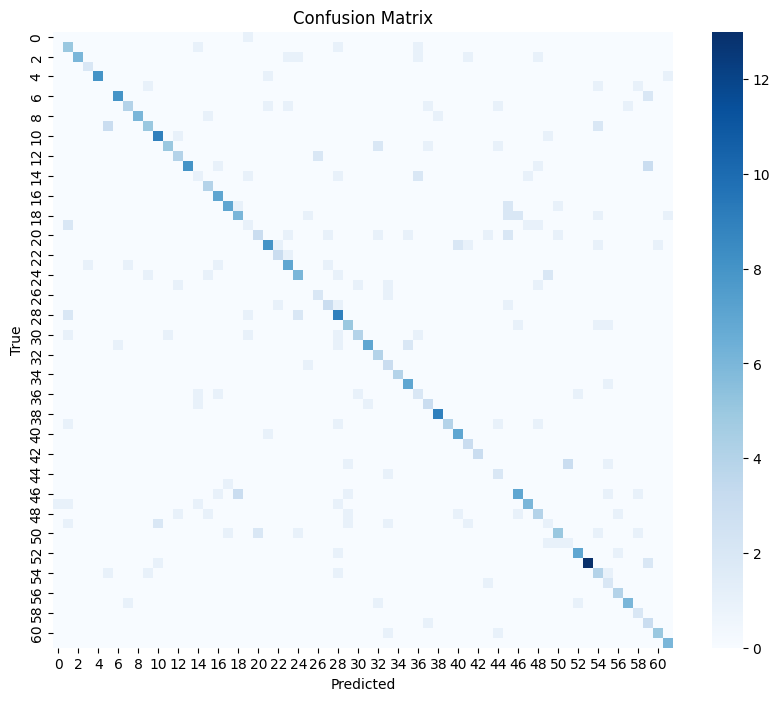

In [ ]:
model_residual_block.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        if use_cuda and torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = model_residual_block(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)

#Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.5114
Class Accuracy: [('Bharadvajas Twist', 0.5), ('Bound Angle Pose', 0.3333333333333333), ('Bow Pose', 0.4), ('Camel Pose', 0.7692307692307693), ('Chair Pose', 0.3333333333333333), ('Cobra Pose', 0.8571428571428571), ('Cow Face Pose', 0.46153846153846156), ('Cow Pose', 0.6818181818181818), ('Crane Pose', 0.8181818181818182), ('Crescent Moon Pose', 0.5714285714285714), ('Downward Dog Pose', 0.2857142857142857), ('Eagle Pose', 0.3333333333333333), ('Easy Pose', 0.4444444444444444), ('Embryo Pose', 0.75), ('Extended Hand to Big Toe Pose', 0.6), ('Extended Side Angle Pose', 0.375), ('Extended Triangle Pose', 0.3333333333333333), ('Formidable Pose', 0.25), ('Four-Limbed Staff Pose', 0.8125), ('Frog Pose', 0.3333333333333333), ('Full Boat Pose', 0.75), ('Garland Pose', 0.625), ('Half Feather Peacock Pose', 0.6), ('Half Frog Pose', 0.0), ('Half Lord of the Fishes Pose', 0.4666666666666667), ('Half Moon Pose', 0.4), ('Hero Pose', 0.

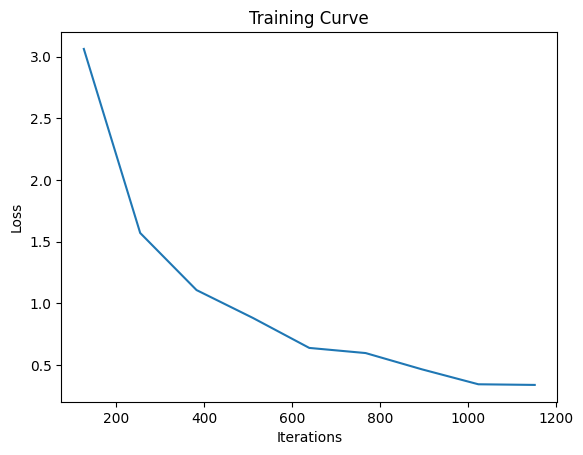

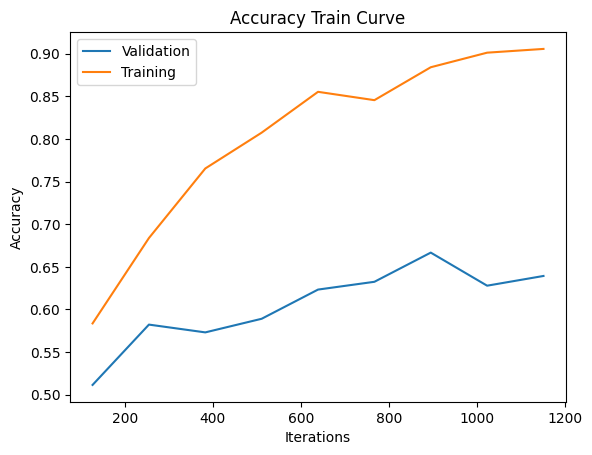

In [ ]:
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.4566
Overall Accuracy: 0.5890
Epoch 1, Loss: 2.800
	Time Elapsed: 19.79 s
Overall Accuracy: 0.5708
Overall Accuracy: 0.6828
Epoch 2, Loss: 1.518
	Time Elapsed: 39.35 s
Overall Accuracy: 0.5936
Overall Accuracy: 0.7683
Epoch 3, Loss: 1.170
	Time Elapsed: 59.45 s
Overall Accuracy: 0.5822
Overall Accuracy: 0.8060
Epoch 4, Loss: 0.901
	Time Elapsed: 78.89 s
Overall Accuracy: 0.6119
Overall Accuracy: 0.8192
Epoch 5, Loss: 0.742
	Time Elapsed: 98.90 s
Overall Accuracy: 0.6050
Overall Accuracy: 0.8539
Epoch 6, Loss: 0.618
	Time Elapsed: 118.89 s
Overall Accuracy: 0.6210
Overall Accuracy: 0.8895
Epoch 7, Loss: 0.490
	Time Elapsed: 138.32 s
Overall Accuracy: 0.6301
Overall Accuracy: 0.9037
Epoch 8, Loss: 0.393
	Time Elapsed: 158.45 s
Overall Accuracy: 0.6461
Overall Accuracy: 0.9164
Epoch 9, Loss: 0.370
	Time Elapsed: 178.02 s
Overall Accuracy: 0.6393
Overall Accuracy: 0.9360
Epoch 10, Loss: 0.306
	Time Elapsed: 198.07 s
Final Training

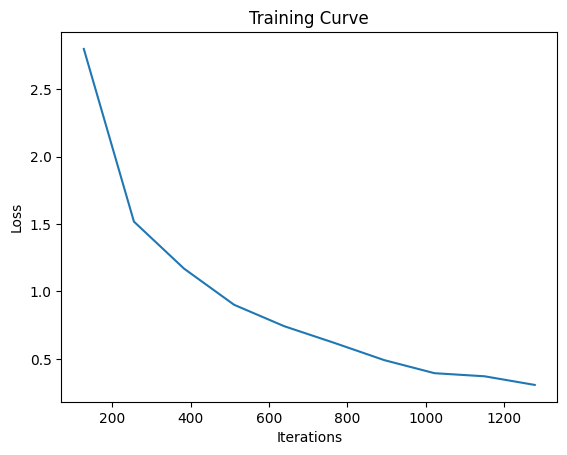

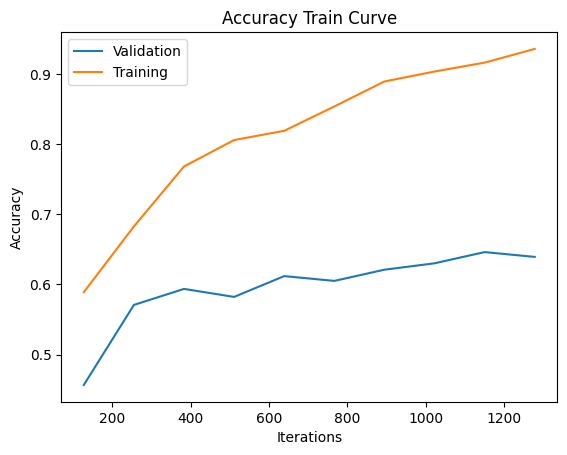

In [ ]:
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, learning_rate=0.0002)

'''Pick lr = 0.002'''

### Batch Size

In [ ]:
# Define batch size
batch_size = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.4726
Overall Accuracy: 0.5630
Epoch 1, Loss: 3.004
	Time Elapsed: 26.97 s
Overall Accuracy: 0.5479
Overall Accuracy: 0.6940
Epoch 2, Loss: 1.586
	Time Elapsed: 54.30 s
Overall Accuracy: 0.5479
Overall Accuracy: 0.7463
Epoch 3, Loss: 1.168
	Time Elapsed: 81.59 s
Overall Accuracy: 0.5890
Overall Accuracy: 0.8040
Epoch 4, Loss: 0.910
	Time Elapsed: 113.86 s
Overall Accuracy: 0.5776
Overall Accuracy: 0.8343
Epoch 5, Loss: 0.745
	Time Elapsed: 155.84 s
Overall Accuracy: 0.6210
Overall Accuracy: 0.8573
Epoch 6, Loss: 0.584
	Time Elapsed: 183.01 s
Overall Accuracy: 0.5959
Overall Accuracy: 0.8710
Epoch 7, Loss: 0.497
	Time Elapsed: 209.93 s
Overall Accuracy: 0.6187
Overall Accuracy: 0.9066
Epoch 8, Loss: 0.402
	Time Elapsed: 236.83 s
Early stopping triggered at epoch 8
Final Training Accuracy: 0.9066471163245357
Final Validation Accuracy: 0.6210045662100456


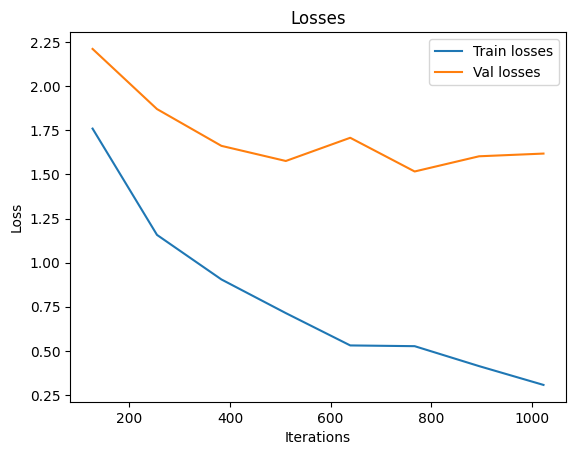

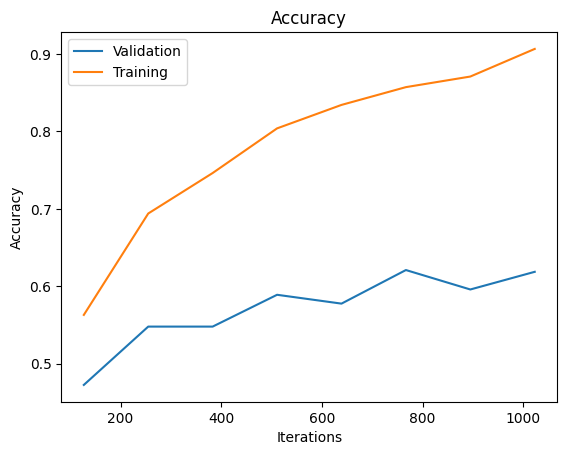

In [ ]:
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, batch_size = 16, learning_rate=0.0002)

In [ ]:
# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.4521
Overall Accuracy: 0.5425
Epoch 1, Loss: 2.891
	Time Elapsed: 31.01 s
Overall Accuracy: 0.5365
Overall Accuracy: 0.6740
Epoch 2, Loss: 1.604
	Time Elapsed: 60.16 s
Overall Accuracy: 0.5936
Overall Accuracy: 0.7493
Epoch 3, Loss: 1.191
	Time Elapsed: 88.75 s
Overall Accuracy: 0.5936
Overall Accuracy: 0.7859
Epoch 4, Loss: 0.918
	Time Elapsed: 115.97 s
Overall Accuracy: 0.6027
Overall Accuracy: 0.8368
Epoch 5, Loss: 0.745
	Time Elapsed: 142.60 s
Overall Accuracy: 0.6096
Overall Accuracy: 0.8685
Epoch 6, Loss: 0.649
	Time Elapsed: 169.24 s
Overall Accuracy: 0.6073
Overall Accuracy: 0.8754
Epoch 7, Loss: 0.489
	Time Elapsed: 195.85 s
Overall Accuracy: 0.6347
Overall Accuracy: 0.9091
Epoch 8, Loss: 0.384
	Time Elapsed: 223.55 s
Overall Accuracy: 0.6575
Overall Accuracy: 0.9213
Epoch 9, Loss: 0.345
	Time Elapsed: 250.26 s
Overall Accuracy: 0.6096
Overall Accuracy: 0.9179
Epoch 10, Loss: 0.325
	Time Elapsed: 277.32 s
Final Traini

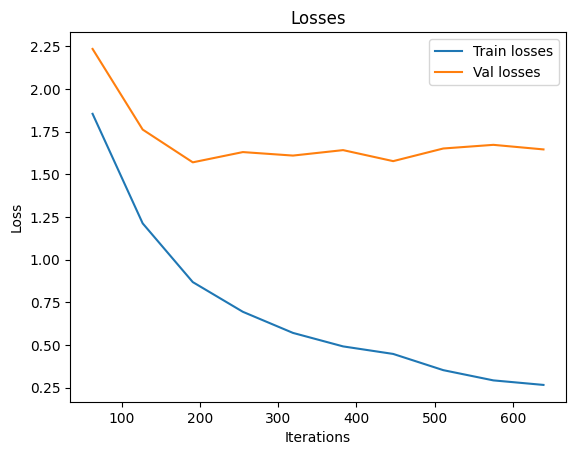

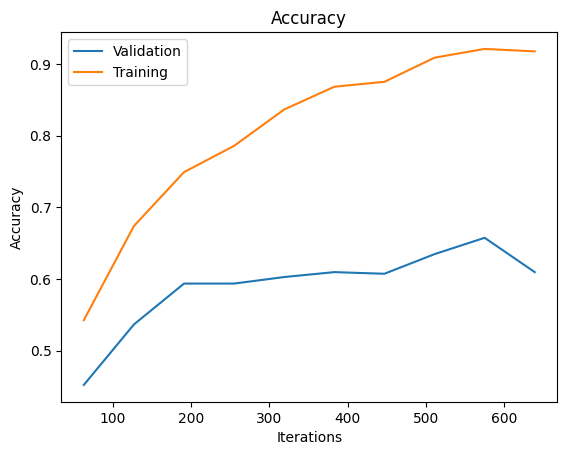

In [ ]:
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, batch_size = 32, learning_rate=0.0002)

In [ ]:
# Define batch size
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.0731
Overall Accuracy: 0.1261
Epoch 1, Loss: 3.040
	Time Elapsed: 26.77 s
Overall Accuracy: 0.5274
Overall Accuracy: 0.6251
Epoch 2, Loss: 1.723
	Time Elapsed: 53.26 s
Overall Accuracy: 0.5753
Overall Accuracy: 0.7527
Epoch 3, Loss: 1.270
	Time Elapsed: 79.66 s
Overall Accuracy: 0.5685
Overall Accuracy: 0.7600
Epoch 4, Loss: 1.008
	Time Elapsed: 106.04 s
Overall Accuracy: 0.6301
Overall Accuracy: 0.8216
Epoch 5, Loss: 0.786
	Time Elapsed: 132.41 s
Overall Accuracy: 0.6005
Overall Accuracy: 0.8328
Epoch 6, Loss: 0.710
	Time Elapsed: 158.73 s
Overall Accuracy: 0.6164
Overall Accuracy: 0.8568
Epoch 7, Loss: 0.551
	Time Elapsed: 185.63 s
Overall Accuracy: 0.5799
Overall Accuracy: 0.8881
Epoch 8, Loss: 0.477
	Time Elapsed: 212.38 s
Overall Accuracy: 0.6005
Overall Accuracy: 0.8998
Epoch 9, Loss: 0.418
	Time Elapsed: 238.89 s
Early stopping triggered at epoch 9
Final Training Accuracy: 0.8998044965786901
Final Validation Accuracy: 0

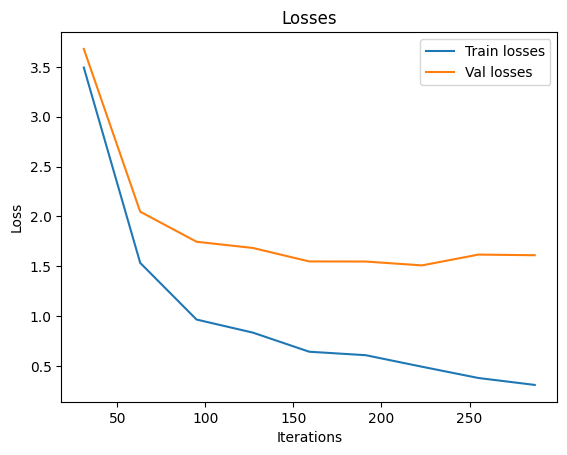

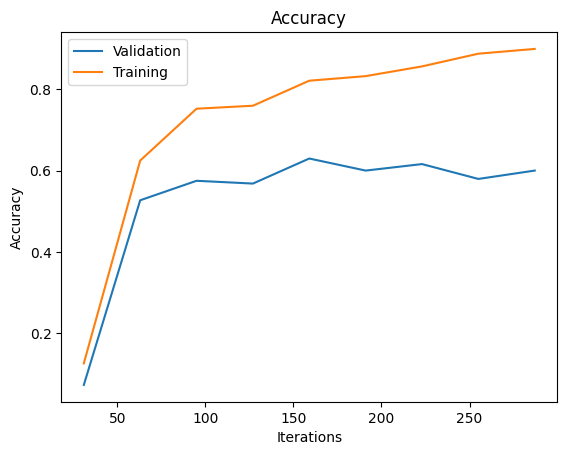

In [ ]:
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, batch_size = 64, learning_rate=0.0002)

In [ ]:
# Define batch size
batch_size = 128

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.0320
Overall Accuracy: 0.0464
Epoch 1, Loss: 3.141
	Time Elapsed: 26.05 s
Overall Accuracy: 0.2032
Overall Accuracy: 0.2757
Epoch 2, Loss: 1.771
	Time Elapsed: 52.10 s
Overall Accuracy: 0.4932
Overall Accuracy: 0.6290
Epoch 3, Loss: 1.365
	Time Elapsed: 77.95 s
Overall Accuracy: 0.5342
Overall Accuracy: 0.7224
Epoch 4, Loss: 1.093
	Time Elapsed: 104.08 s
Overall Accuracy: 0.6256
Overall Accuracy: 0.7810
Epoch 5, Loss: 0.849
	Time Elapsed: 130.08 s
Overall Accuracy: 0.5868
Overall Accuracy: 0.8250
Epoch 6, Loss: 0.722
	Time Elapsed: 155.99 s
Overall Accuracy: 0.6027
Overall Accuracy: 0.8368
Epoch 7, Loss: 0.643
	Time Elapsed: 182.10 s
Overall Accuracy: 0.6324
Overall Accuracy: 0.8871
Epoch 8, Loss: 0.519
	Time Elapsed: 208.57 s
Overall Accuracy: 0.6164
Overall Accuracy: 0.8871
Epoch 9, Loss: 0.463
	Time Elapsed: 234.67 s
Overall Accuracy: 0.6324
Overall Accuracy: 0.9091
Epoch 10, Loss: 0.370
	Time Elapsed: 260.63 s
Final Traini

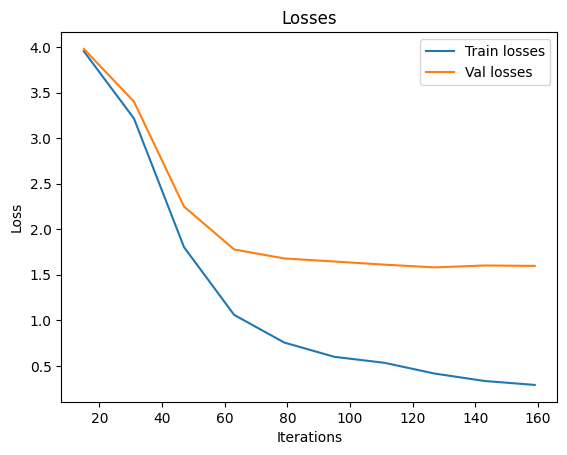

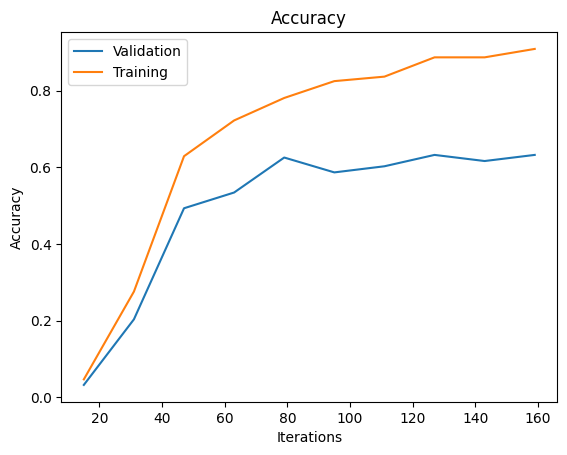

In [ ]:
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, batch_size = 128, learning_rate=0.0002)

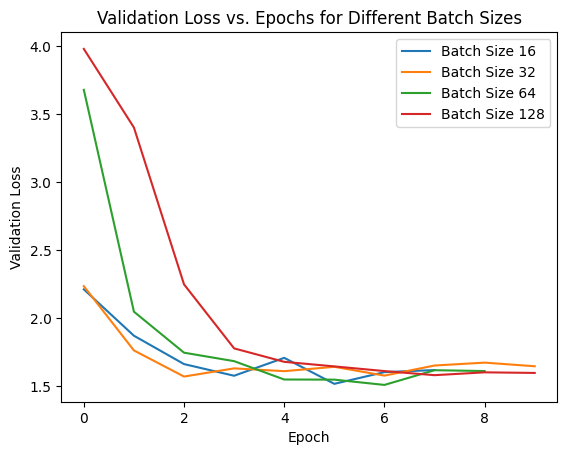

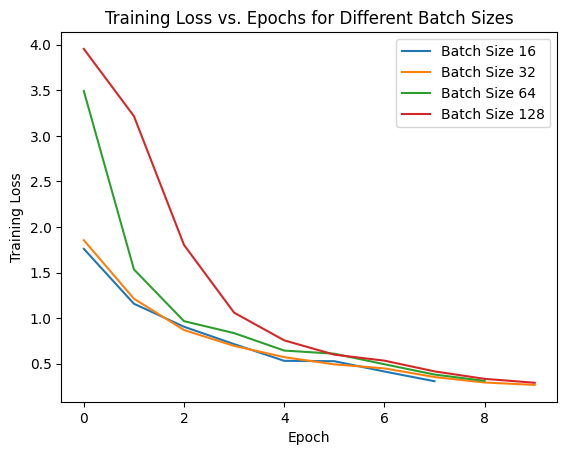

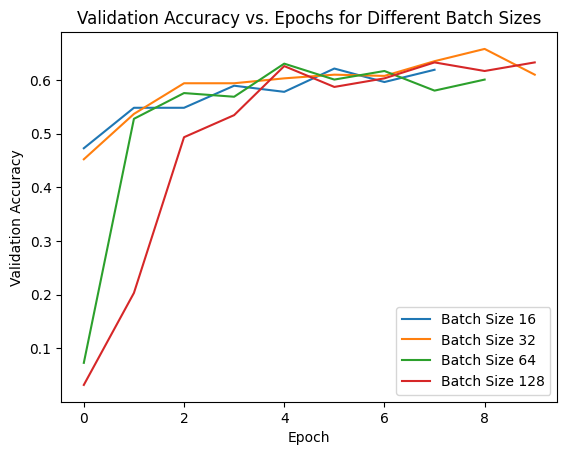

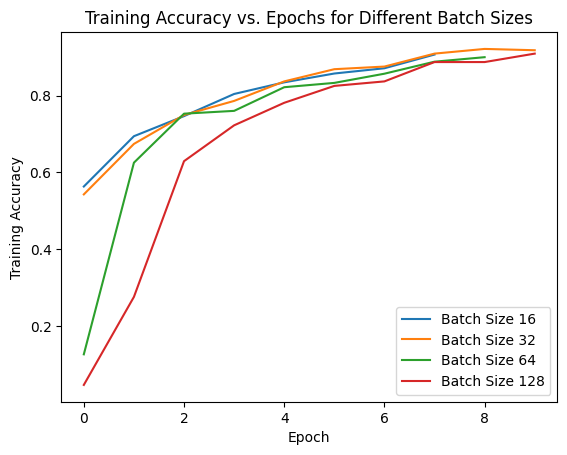

In [ ]:
plot_global_metrics()

### Batches = 32

### Number of epochs

In [ ]:
# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.3858
Overall Accuracy: 0.4878
Epoch 1, Loss: 3.021
	Time Elapsed: 31.76 s
Overall Accuracy: 0.5502
Overall Accuracy: 0.6720
Epoch 2, Loss: 1.681
	Time Elapsed: 58.34 s
Overall Accuracy: 0.5594
Overall Accuracy: 0.7566
Epoch 3, Loss: 1.225
	Time Elapsed: 85.39 s
Final Training Accuracy: 0.7565982404692082
Final Validation Accuracy: 0.5593607305936074


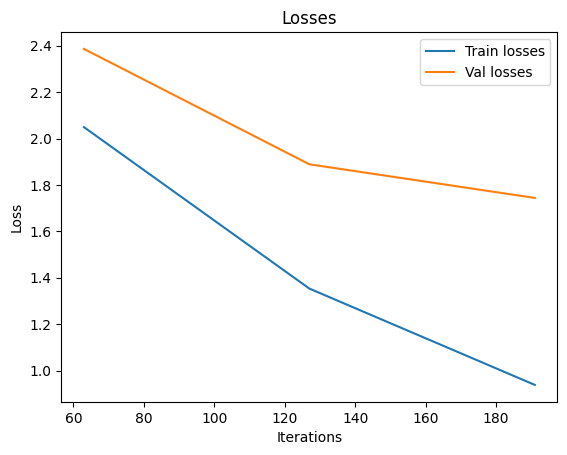

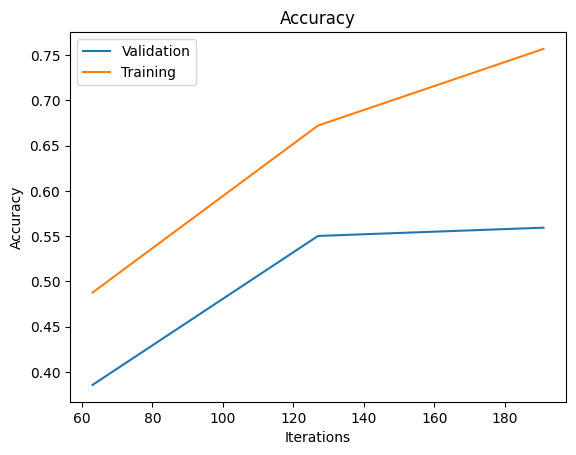

In [ ]:
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=3, batch_size = 32, learning_rate=0.0002)

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.4406
Overall Accuracy: 0.5318
Epoch 1, Loss: 2.969
	Time Elapsed: 26.57 s
Overall Accuracy: 0.5685
Overall Accuracy: 0.6940
Epoch 2, Loss: 1.661
	Time Elapsed: 54.41 s
Overall Accuracy: 0.6027
Overall Accuracy: 0.7483
Epoch 3, Loss: 1.243
	Time Elapsed: 81.35 s
Overall Accuracy: 0.6050
Overall Accuracy: 0.7869
Epoch 4, Loss: 0.955
	Time Elapsed: 108.42 s
Overall Accuracy: 0.5959
Overall Accuracy: 0.8162
Epoch 5, Loss: 0.777
	Time Elapsed: 135.40 s
Final Training Accuracy: 0.8162267839687195
Final Validation Accuracy: 0.6050228310502284


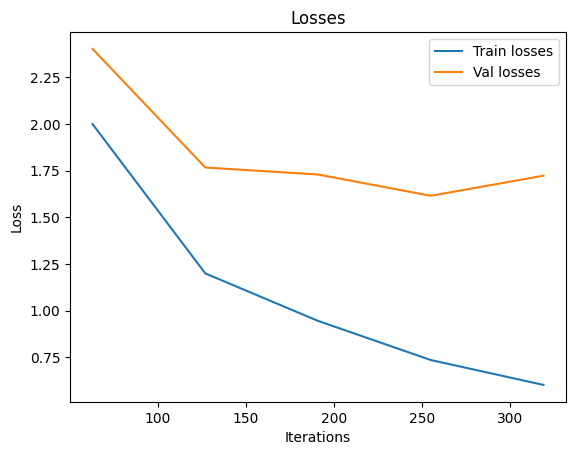

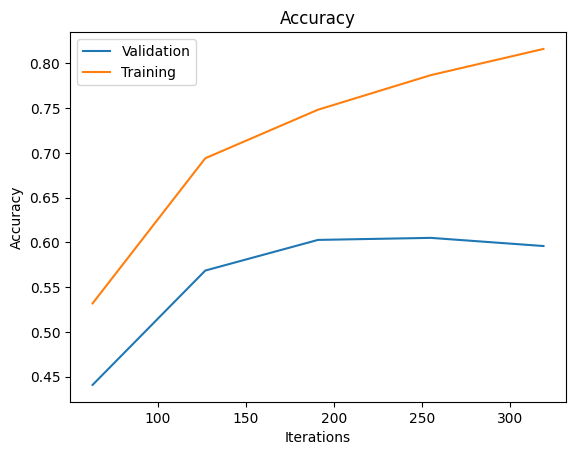

In [ ]:
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=5, batch_size = 32, learning_rate=0.0002)

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.4132
Overall Accuracy: 0.4785
Epoch 1, Loss: 2.969
	Time Elapsed: 27.50 s
Overall Accuracy: 0.5068
Overall Accuracy: 0.6730
Epoch 2, Loss: 1.711
	Time Elapsed: 55.20 s
Overall Accuracy: 0.5822
Overall Accuracy: 0.7439
Epoch 3, Loss: 1.270
	Time Elapsed: 82.44 s
Overall Accuracy: 0.5411
Overall Accuracy: 0.7551
Epoch 4, Loss: 1.022
	Time Elapsed: 109.11 s
Overall Accuracy: 0.5799
Overall Accuracy: 0.8187
Epoch 5, Loss: 0.804
	Time Elapsed: 135.76 s
Overall Accuracy: 0.5982
Overall Accuracy: 0.8548
Epoch 6, Loss: 0.659
	Time Elapsed: 163.93 s
Overall Accuracy: 0.6553
Overall Accuracy: 0.8788
Epoch 7, Loss: 0.521
	Time Elapsed: 190.71 s
Overall Accuracy: 0.5890
Overall Accuracy: 0.8910
Epoch 8, Loss: 0.451
	Time Elapsed: 217.62 s
Overall Accuracy: 0.6142
Overall Accuracy: 0.9169
Epoch 9, Loss: 0.409
	Time Elapsed: 250.06 s
Overall Accuracy: 0.6096
Overall Accuracy: 0.9125
Epoch 10, Loss: 0.359
	Time Elapsed: 276.84 s
Final Traini

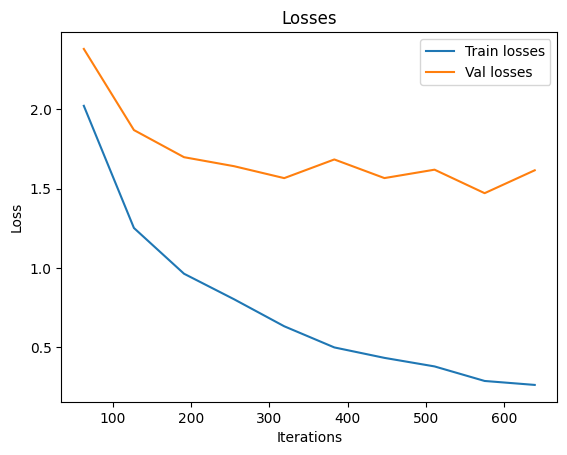

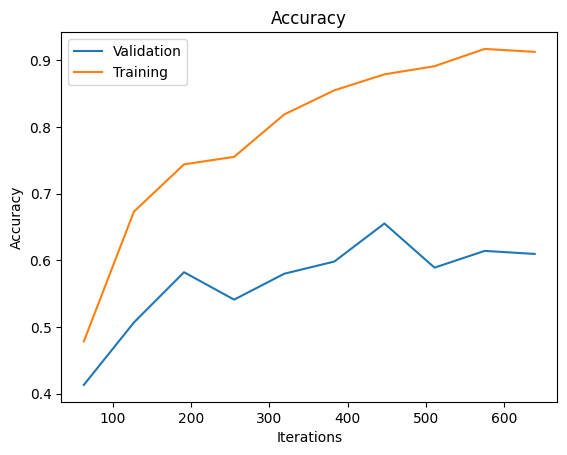

In [ ]:
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, batch_size = 32, learning_rate=0.0002)

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.4178
Overall Accuracy: 0.4980
Epoch 1, Loss: 2.915
	Time Elapsed: 26.88 s
Overall Accuracy: 0.5068
Overall Accuracy: 0.6657
Epoch 2, Loss: 1.639
	Time Elapsed: 53.83 s
Overall Accuracy: 0.5822
Overall Accuracy: 0.7454
Epoch 3, Loss: 1.257
	Time Elapsed: 80.96 s
Overall Accuracy: 0.5822
Overall Accuracy: 0.7776
Epoch 4, Loss: 0.940
	Time Elapsed: 107.74 s
Overall Accuracy: 0.5913
Overall Accuracy: 0.8221
Epoch 5, Loss: 0.782
	Time Elapsed: 134.48 s
Overall Accuracy: 0.6279
Overall Accuracy: 0.8451
Epoch 6, Loss: 0.650
	Time Elapsed: 161.14 s
Overall Accuracy: 0.6164
Overall Accuracy: 0.8631
Epoch 7, Loss: 0.556
	Time Elapsed: 187.80 s
Overall Accuracy: 0.6347
Overall Accuracy: 0.8891
Epoch 8, Loss: 0.479
	Time Elapsed: 214.51 s
Overall Accuracy: 0.6164
Overall Accuracy: 0.8983
Epoch 9, Loss: 0.396
	Time Elapsed: 242.72 s
Overall Accuracy: 0.6553
Overall Accuracy: 0.9272
Epoch 10, Loss: 0.336
	Time Elapsed: 270.09 s
Overall Accu

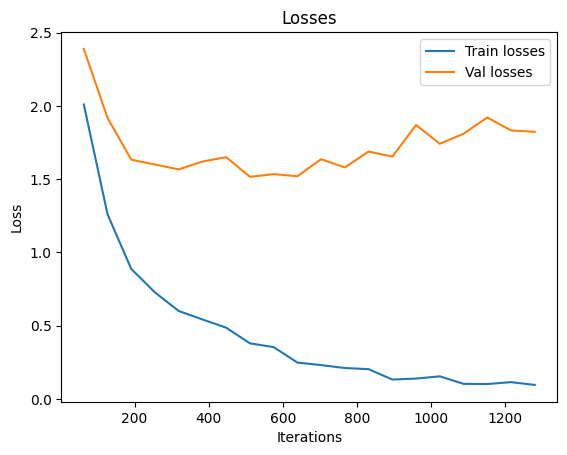

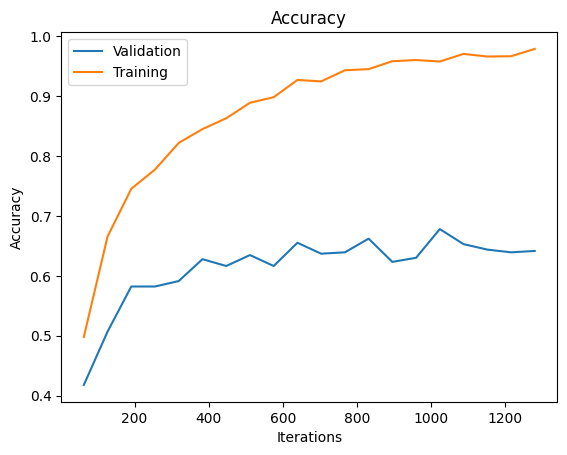

In [ ]:
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=20, batch_size = 32, learning_rate=0.0002)

'''Tuning Number of filters"

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.5046
Overall Accuracy: 0.5802
Epoch 1, Loss: 2.939
	Time Elapsed: 28.60 s
Overall Accuracy: 0.5251
Overall Accuracy: 0.6989
Epoch 2, Loss: 1.533
	Time Elapsed: 57.13 s
Overall Accuracy: 0.5685
Overall Accuracy: 0.7600
Epoch 3, Loss: 1.074
	Time Elapsed: 85.82 s
Overall Accuracy: 0.5982
Overall Accuracy: 0.7845
Epoch 4, Loss: 0.863
	Time Elapsed: 115.50 s
Overall Accuracy: 0.6142
Overall Accuracy: 0.8412
Epoch 5, Loss: 0.703
	Time Elapsed: 143.83 s
Overall Accuracy: 0.6370
Overall Accuracy: 0.8749
Epoch 6, Loss: 0.569
	Time Elapsed: 172.67 s
Overall Accuracy: 0.6416
Overall Accuracy: 0.8998
Epoch 7, Loss: 0.475
	Time Elapsed: 200.81 s
Overall Accuracy: 0.6598
Overall Accuracy: 0.9213
Epoch 8, Loss: 0.369
	Time Elapsed: 229.15 s
Overall Accuracy: 0.6073
Overall Accuracy: 0.9286
Epoch 9, Loss: 0.312
	Time Elapsed: 257.95 s
Overall Accuracy: 0.6370
Overall Accuracy: 0.9370
Epoch 10, Loss: 0.283
	Time Elapsed: 286.28 s
Final Traini

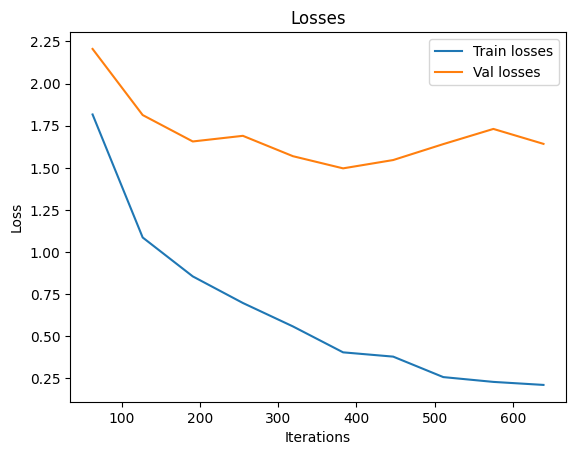

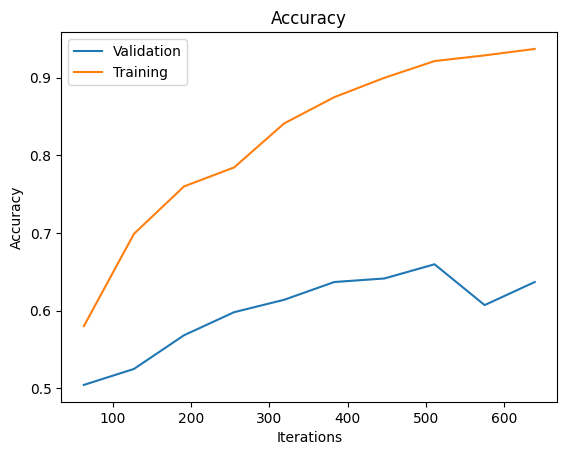

In [ ]:
'''input = 16'''
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, batch_size = 32, learning_rate=0.0002)

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.4543
Overall Accuracy: 0.5606
Epoch 1, Loss: 3.218
	Time Elapsed: 30.72 s
Overall Accuracy: 0.5571
Overall Accuracy: 0.6916
Epoch 2, Loss: 1.546
	Time Elapsed: 62.03 s
Overall Accuracy: 0.5868
Overall Accuracy: 0.7693
Epoch 3, Loss: 1.152
	Time Elapsed: 93.98 s
Overall Accuracy: 0.6119
Overall Accuracy: 0.8060
Epoch 4, Loss: 0.897
	Time Elapsed: 125.49 s
Overall Accuracy: 0.5868
Overall Accuracy: 0.8226
Epoch 5, Loss: 0.655
	Time Elapsed: 155.94 s
Overall Accuracy: 0.6073
Overall Accuracy: 0.8700
Epoch 6, Loss: 0.545
	Time Elapsed: 187.22 s
Overall Accuracy: 0.6027
Overall Accuracy: 0.8920
Epoch 7, Loss: 0.512
	Time Elapsed: 217.90 s
Overall Accuracy: 0.6279
Overall Accuracy: 0.8886
Epoch 8, Loss: 0.393
	Time Elapsed: 249.16 s
Overall Accuracy: 0.6438
Overall Accuracy: 0.9120
Epoch 9, Loss: 0.334
	Time Elapsed: 279.75 s
Overall Accuracy: 0.6370
Overall Accuracy: 0.9365
Epoch 10, Loss: 0.274
	Time Elapsed: 311.18 s
Final Traini

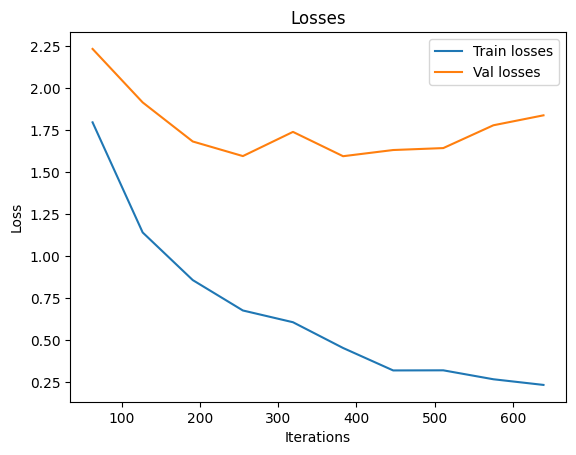

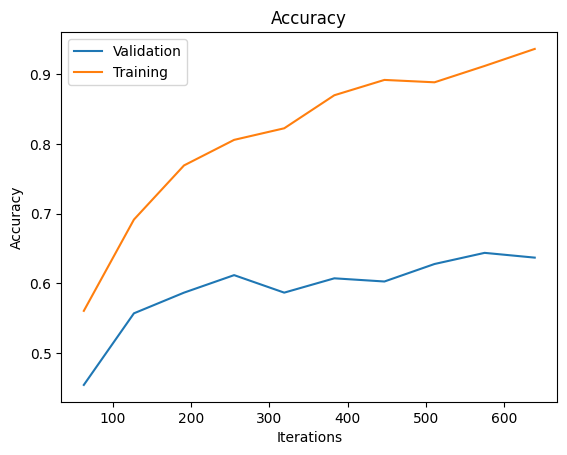

In [ ]:
'''input = 32'''
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, batch_size = 32, learning_rate=0.0002)

CUDA is available!  Training on GPU ...
Overall Accuracy: 0.4566
Overall Accuracy: 0.5601
Epoch 1, Loss: 3.977
	Time Elapsed: 39.06 s
Overall Accuracy: 0.4932
Overall Accuracy: 0.6657
Epoch 2, Loss: 1.684
	Time Elapsed: 77.55 s
Overall Accuracy: 0.5776
Overall Accuracy: 0.7581
Epoch 3, Loss: 1.178
	Time Elapsed: 118.20 s
Overall Accuracy: 0.6027
Overall Accuracy: 0.8069
Epoch 4, Loss: 0.896
	Time Elapsed: 156.70 s
Overall Accuracy: 0.5594
Overall Accuracy: 0.8245
Epoch 5, Loss: 0.769
	Time Elapsed: 195.07 s
Overall Accuracy: 0.6096
Overall Accuracy: 0.8666
Epoch 6, Loss: 0.628
	Time Elapsed: 233.92 s
Overall Accuracy: 0.6027
Overall Accuracy: 0.8680
Epoch 7, Loss: 0.536
	Time Elapsed: 272.97 s
Overall Accuracy: 0.6256
Overall Accuracy: 0.8920
Epoch 8, Loss: 0.402
	Time Elapsed: 311.34 s
Overall Accuracy: 0.6005
Overall Accuracy: 0.9013
Epoch 9, Loss: 0.376
	Time Elapsed: 349.80 s
Overall Accuracy: 0.6301
Overall Accuracy: 0.9169
Epoch 10, Loss: 0.311
	Time Elapsed: 388.00 s
Final Train

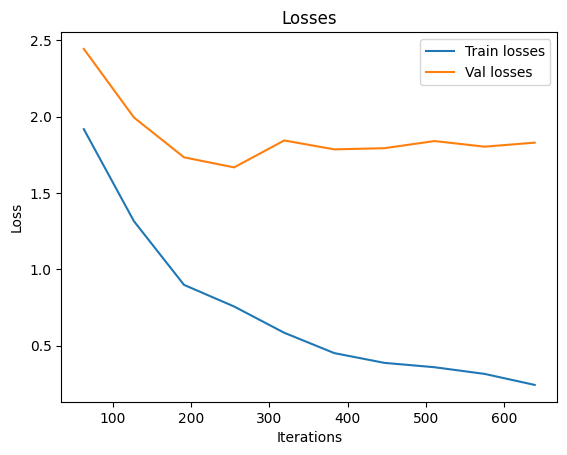

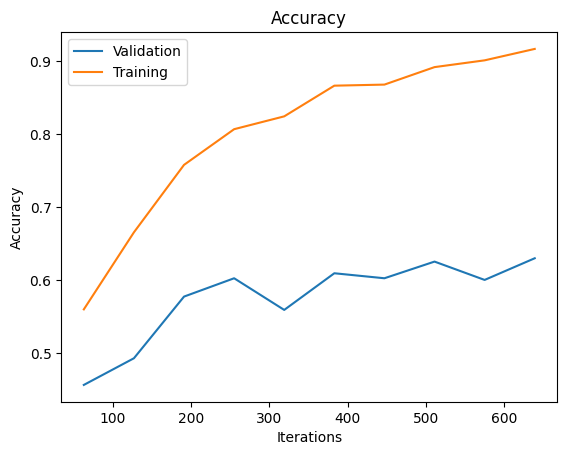

In [ ]:
'''input = 64'''
model_residual_block = ResNetSimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model_residual_block.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot2(model_residual_block, num_epochs=10, batch_size = 32, learning_rate=0.0002)

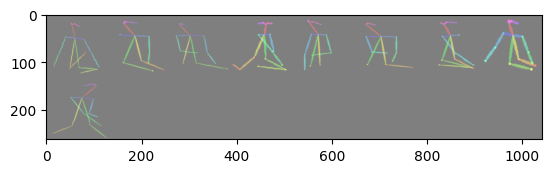

Bharadvajas Twist Bharadvajas Twist Bharadvajas Twist Bharadvajas Twist Bharadvajas Twist Bharadvajas Twist Bharadvajas Twist Bharadvajas Twist Bharadvajas Twist


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

# Function to unnormalize and show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if normalized with mean=0.5, std=0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Specify the target class
target_class = 'Bharadvajas Twist'  # Replace with your desired class
target_class_idx = dataset.classes.index(target_class)

# Collect images of the specified class
images_of_class = []
labels_of_class = []

for images, labels in val_loader:
    for i in range(len(labels)):
        if labels[i].item() == target_class_idx:
            images_of_class.append(images[i])
            labels_of_class.append(labels[i])

    # Stop when you have enough images to display
    if len(images_of_class) >= 10:  # Display first 10 images
        break

# Convert list to tensor
images_of_class = torch.stack(images_of_class[:10])  # Only take first 10 images
labels_of_class = labels_of_class[:10]

# Show images
imshow(torchvision.utils.make_grid(images_of_class))

# Print corresponding labels (optional)
print(' '.join(f'{dataset.classes[labels_of_class[j]]}' for j in range(len(labels_of_class))))


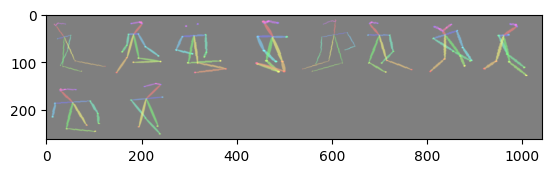

Bharadvajas Twist Bharadvajas Twist Bharadvajas Twist Bharadvajas Twist Bharadvajas Twist Bharadvajas Twist Bharadvajas Twist Bharadvajas Twist Bharadvajas Twist Bharadvajas Twist


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

# Function to unnormalize and show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if normalized with mean=0.5, std=0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Specify the target class
target_class = 'Bharadvajas Twist'  # Replace with your desired class
target_class_idx = dataset.classes.index(target_class)

# Collect images of the specified class
images_of_class = []
labels_of_class = []

for images, labels in train_loader:
    for i in range(len(labels)):
        if labels[i].item() == target_class_idx:
            images_of_class.append(images[i])
            labels_of_class.append(labels[i])

    # Stop when you have enough images to display
    if len(images_of_class) >= 10:  # Display first 10 images
        break

# Convert list to tensor
images_of_class = torch.stack(images_of_class[:10])  # Only take first 10 images
labels_of_class = labels_of_class[:10]

# Show images
imshow(torchvision.utils.make_grid(images_of_class))

# Print corresponding labels (optional)
print(' '.join(f'{dataset.classes[labels_of_class[j]]}' for j in range(len(labels_of_class))))


In [ ]:
test_acc=get_accuracy2(model, test_loader)
print(f'Final Test Accuracy: {100 * test_acc:.2f}%')

In [ ]:
print(global_train_accuracy_batch_size)
print(global_train_loss_batch_size)
print(global_val_accuracy_batch_size)
print(global_val_loss_batch_size)

[(16, [0.5630498533724341, 0.6940371456500489, 0.7463343108504399, 0.8040078201368523, 0.8343108504398827, 0.8572825024437928, 0.8709677419354839, 0.9066471163245357]), (32, [0.5425219941348973, 0.6739980449657869, 0.749266862170088, 0.7859237536656891, 0.8367546432062561, 0.8685239491691105, 0.875366568914956, 0.9090909090909091, 0.9213098729227761, 0.9178885630498533]), (64, [0.12609970674486803, 0.6251221896383187, 0.7526881720430108, 0.760019550342131, 0.821603128054741, 0.8328445747800587, 0.8567937438905181, 0.8880742913000977, 0.8998044965786901]), (128, [0.04643206256109482, 0.2756598240469208, 0.6290322580645161, 0.7223851417399805, 0.7810361681329423, 0.8250244379276638, 0.8367546432062561, 0.8870967741935484, 0.8870967741935484, 0.9090909090909091])]
[(16, [1.7601195329095611, 1.1574911644148804, 0.9049202507308968, 0.7140776198047813, 0.5308042419737502, 0.5265713542670681, 0.4135131614823495, 0.30690397163406963]), (32, [1.85484627824375, 1.2129983224943353, 0.868868814652

In [ ]:
total_params = sum(p.numel() for p in model_residual_block.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")


Total number of parameters: 67407479


In [ ]:
model_residual_block = ResNetSimpleCNN()

In [ ]:
total_params = sum(p.numel() for p in model_residual_block.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 33651543
